# Tidy3D Model

Any number of [models](../models.rst) can be assigned to a [component](../_autosummary/photonforge.Component.rst) to compute its [S matrix](S_Parameters.ipynb).
In this guide, we take a look into the [Tidy3DModel](../_autosummary/photonforge.Tidy3DModel.rst), which leverages the power of Tidy3D to compute the S parameters from FDTD simulations of the 3D device.

## Component Creation

We will create the component based on the [Strip waveguide](Ports.ipynb) available in the [basic technology](../_autosummary/photonforge.basic_technology.rst).
More advanced component creation is described in the [Custom Parametric Components](Custom_Parametric_Components.ipynb) guide.

In [1]:
import numpy as np
import tidy3d as td
import photonforge as pf

pf.config.default_technology = pf.basic_technology(strip_width=0.3)

In [2]:
# Geometry parameters
port_spec = pf.config.default_technology.ports["Strip"]
length = 0.5
radius = 4
gap = 0.15
core_width, _ = port_spec.path_profile_for("WG_CORE")

coupler = pf.Component("COUPLER")

# Add straight section
for layer, path in port_spec.get_paths((0, 0)):
    path.segment((2 * radius + length, 0))
    coupler.add(layer, path)

# Add racetrack section
for layer, path in port_spec.get_paths((0, core_width + gap + radius)):
    path.arc(180, 270, radius, euler_fraction=0.5)
    path.segment((length, 0), relative=True)
    path.arc(-90, 0, radius, euler_fraction=0.5)
    coupler.add(layer, path)

# Add ports
coupler.add_port(coupler.detect_ports([port_spec]))

coupler

## Create the Tidy3D Model

The Tidy3D model supports many arguments related to the configurations of the FDTD simulation that will be run.
One is particularly important for most devices: setting `port_symmetries`.
Without specification, the default behavior is to execute 1 FDTD simulation per component port, so that the full S matrix can be computed.
In many cases, though, because of device symmetries, it is possible to reuse the results from one simulation in place of others.

In our example, if we simulate the field distribution using port P0 as input, we can use the same results to deduce the fields when the input is at port P2, as long as we properly account for polarization-specific phase inversions.
We describe this symmetry as follows: `("P0" ,"P2", {"P2": "P0", "P1": "P3", "P3": "P1"})`, that is, the results from input at P0 can be mapped to input at P2 (first 2 items) by replacing P2 with P0, P1 with P3, and P3 with P1 (dictionary). In general, the tuple `(j, n, {i: m})` indicates that $S_{mn}$ should be calculated from $S_{ij}$ (and $S_{nn}$ from $S_{jj}$ is also implied).

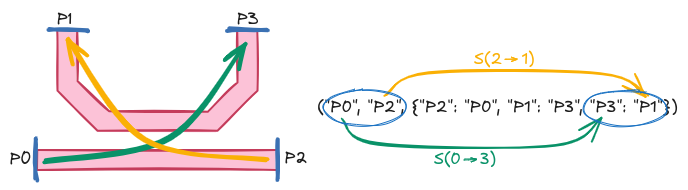

By setting the proper symmetries, our device can be completely characterized from 2 FDTD runs (and a few mode solver runs for phase correction) instead of 4 FDTD runs.

In [3]:
port_symmetries = [
    ("P0", "P2", {"P2": "P0", "P1": "P3", "P3": "P1"}),
    ("P1", "P3", {"P0": "P2", "P2": "P0", "P3": "P1"}),
]

model = pf.Tidy3DModel(port_symmetries=port_symmetries)

coupler.add_model(model, "Tidy3DModel")
coupler.models

{'Tidy3DModel': Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=(), structures=(), grid_spec=None, shutoff=1e-05, subpixel=True, courant=0.99, port_symmetries=[('P0', 'P2', {'P2': 'P0', 'P1': 'P3', 'P3': 'P1', 'P0': 'P2'}), ('P1', 'P3', {'P0': 'P2', 'P2': 'P0', 'P3': 'P1', 'P1': 'P3'})], bounds=((None, None, None), (None, None, None)), verbose=True)}

## Credit Estimation and Running

Now we are ready to compute the S parameters, but we might want to estimate the cost of our simulations before that.
The function [get_simulations](../_autosummary/photonforge.Tidy3DModel.rst#photonforge.Tidy3DModel.get_simulations) generates all simulations that will be run by the model. With them, we can create a [Batch](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.web.api.container.Batch.html) to estimate the cost.

Note that, by default, PhotonForge overestimates the runtime to make sure the simulation reaches the shut-off condition without us having to set anything up. That means that the estimated cost is usually much higher than the real cost that will be charged for the run.

In [4]:
freqs = pf.C_0 / np.linspace(1.28, 1.36, 9)

simulations = model.get_simulations(coupler, freqs)

td.web.Batch(simulations=simulations).estimate_cost()

06:40:59 -03 Maximum FlexCredit cost: 4.417 for the whole batch.

4.417386786113026

Now let's compute and plot the S parameters:

Starting...
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-YQUMBQ5GVT54MOHL72VJHQG2364P5YCNWQGBUHLTW6KFJ4WXCLLA.json.
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-2J25C7GYUZKJXES3RBCAP4QRGLIF672X7EXG5EYS3WG7O6PNCFBA.json.
Progress: 100% 


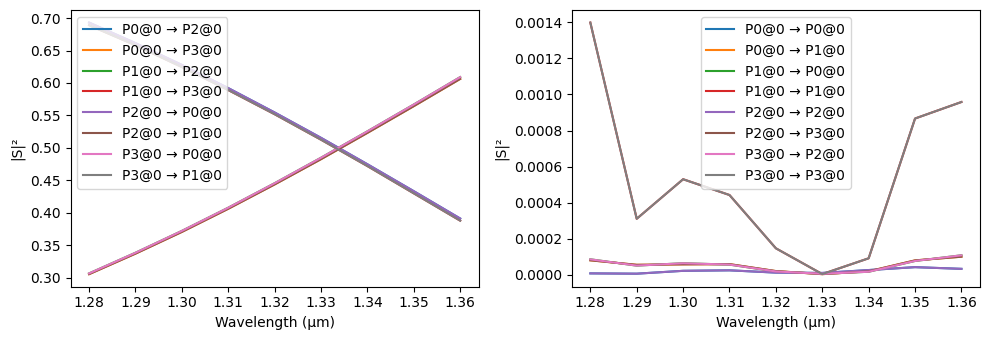

In [5]:
_ = pf.plot_s_matrix(coupler.s_matrix(freqs))

### Calculating Real Cost

After the simulations are run, we can get the associated batch data for the component.
With the task ids stored within, the real simulation cost can be computed:

In [6]:
data = model.batch_data_for(coupler)

total_cost = sum(td.web.real_cost(task_id) for task_id in data.task_ids.values())
print(f"Total FlexCredit cost: {total_cost:.3f}")

             Billed flex credit cost: 0.612.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

06:41:00 -03 Billed flex credit cost: 0.700.

             Note: the task cost pro-rated due to early shutoff was below the   
             minimum threshold, due to fast shutoff. Decreasing the simulation  
             'run_time' should decrease the estimated, and correspondingly the  
             billed cost of such tasks.

Total FlexCredit cost: 1.312


We see that the total cost is well bellow the estimated cost.
If we want to, we can fine-tune other model parameters, such as `run_time` and `grid_spec`.

## Skipping Unnecessary Runs

There are situations when we are only interested in a single or a few S matrix elements.
In such cases, it is possible to limit the number of simulation runs by selecting the ports we want to be used as sources.
As a result, only the matrix elements from those source will be computed (plus any other allowed by port symmetries).

For example, we can constrain the computation to use only the fundamental mode of port P3 as source:

In [7]:
s_limited = coupler.s_matrix(freqs, model_kwargs={"inputs": ["P3@0"]})
s_limited.elements.keys()

Starting...
Loading cached simulation from .tidy3d/pf_cache/N4H/fdtd_info-FXDIGEF6674BOQT75R3HTMJ6ZFM3ICZFWARR6RDV2YLXABUDSJSQ.json.
Progress: 100% 


dict_keys([('P3@0', 'P0@0'), ('P3@0', 'P1@0'), ('P3@0', 'P2@0'), ('P3@0', 'P3@0')])

## Visualizing The Fields

During early design phases, it might be necessary to visualize the field distributions on the device to guide the design.
That can be accomplished with the Tidy3D model by including a conventional Tidy3D field monitor:

In [8]:
import tidy3d as td

field_monitor = td.FieldMonitor(
    center=(0, 0, 0.11), size=(td.inf, td.inf, 0), freqs=[freqs.mean()], name="field"
)

model2 = pf.Tidy3DModel(monitors=[field_monitor], port_symmetries=port_symmetries, verbose=False)

# The newly added model is set to active automatically
coupler.add_model(model2, "Tidy3DModel2")
coupler.active_model

Tidy3DModel(run_time=None, medium=None, symmetry=(0, 0, 0), boundary_spec=None, monitors=[FieldMonitor(attrs={}, type='FieldMonitor', center=(0.0, 0.0, 0.11), size=(inf, inf, 0.0), name='field', interval_space=(1, 1, 1), colocate=True, freqs=(227202454954557.62,), apodization=ApodizationSpec(attrs={}, start=None, end=None, width=None, type='ApodizationSpec'), fields=('Ex', 'Ey', 'Ez', 'Hx', 'Hy', 'Hz'))], structures=(), grid_spec=None, shutoff=1e-05, subpixel=True, courant=0.99, port_symmetries=[('P0', 'P2', {'P2': 'P0', 'P1': 'P3', 'P3': 'P1', 'P0': 'P2'}), ('P1', 'P3', {'P0': 'P2', 'P2': 'P0', 'P3': 'P1', 'P1': 'P3'})], bounds=((None, None, None), (None, None, None)), verbose=False)

After a new computation with the new model, the batch data from the simulations will contain the field distributions from Tidy3D as usual.

In [9]:
s_matrix = coupler.s_matrix(freqs)

data = coupler.active_model.batch_data_for(coupler)
data.task_ids

Starting...


Progress: 100% 


{'P0@0': 'fdve-732ca19e-d5f2-4931-8524-bacfeb19799f',
 'P1@0': 'fdve-86ce1edd-026d-4e66-a4c2-113941f6339e'}

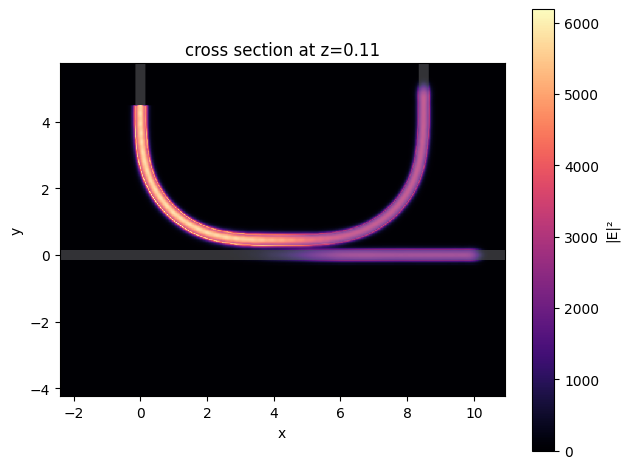

In [10]:
_ = data["P1@0"].plot_field("field", "E", val="abs^2", robust=False)

## Diving Deeper

Finally, it is also possible to get the simulations generated by the Tidy3D model to inspect and customize them at will:

In [11]:
simulations = model2.get_simulations(coupler, freqs)
simulations.keys()

dict_keys(['P0@0', 'P1@0'])

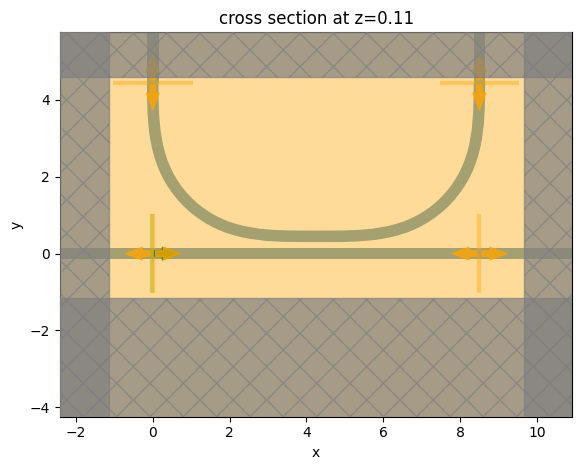

In [12]:
_ = simulations["P0@0"].plot(z=0.11)